### Input data

Dataset from the Lammin Suo peatland station (Saint Petersburg, Russia) is available at Zenodo repository: https://doi.org/10.5281/zenodo.5060038

### Input and output directories:

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os.path
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from pandas.tseries.offsets import MonthEnd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

work_dir = os.path.join(globals()['_dh'][0], "data")

# fig_dir = os.path.dirname(os.path.realpath(__file__))  # __file__ is undefined in Jupyter Notebook
fig_dir = os.path.join(globals()['_dh'][0], "fig")
# print(fig_dir)

### Some helper functions:

In [2]:
def prepare(f, v=False):
    df = pd.read_csv(f, comment='#')
    try:
        datetimes = pd.to_datetime(df["DATE_TIME"])
    except KeyError:
        df.rename(columns={"START_DATE": "DATE_TIME"}, inplace=True)
        datetimes = pd.to_datetime(df["DATE_TIME"])
    df["DATE_TIME"] = datetimes
    df.set_index("DATE_TIME", inplace=True)
    if v:
        df.info()
    return df


def calc_intra_annual(df, mean_col, min_col=None, max_col=None, v=False):
    df["DAY"] = df.index.dayofyear
    # next we need to eliminate Feb 29th: 
    df["DAY"] = np.where(df.index.is_leap_year & (df.index.month > 2), df["DAY"] - 1, df["DAY"])  # we just ignore the existence of 29th Feb
    # display(df.loc[(df["DAY"] > 59) & (df["DAY"] <= 61)])
    
    params = ["mean", "std"]
    col_dict = {mean_col: params}
    if min_col is None:
        params.append("min")
    else:
        col_dict[min_col] = "min"
    if max_col is None:
        params.append("max")
    else:
        col_dict[max_col] = "max"
    
    out_df = df.groupby("DAY").agg(col_dict)
    out_df.columns = ("mean", "std", "min", "max")  # "flattens" grouped columns

    out_df["upper"] = out_df["mean"] + out_df["std"]
    out_df["lower"] = out_df["mean"] - out_df["std"]
    
    # checking if the upper and lower values are within max-min limits:
    out_df["upper"] = np.where(out_df["upper"] > out_df["max"], out_df["max"], out_df["upper"])
    out_df["lower"] = np.where(out_df["lower"] < out_df["min"], out_df["min"], out_df["lower"])
    if v:
        display(out_df)
    return out_df


def plot_intra_annual(df, ax):
    ax.fill_between(df.index, df["upper"], df["lower"], color="lightgrey", label="±SD")
    ax.plot(df.index, df["max"], color="grey", linewidth=1, label="min/max")
    ax.plot(df.index, df["min"], color="grey", linewidth=1)
    ax.plot(df.index, df["mean"], color="k", linewidth=1, label="mean")

    
def mark_axes(ax_tuple, px=-0.1, py=1.15):
    letter = "a"
    for ax in ax_tuple:
        ax.text(px, py, "(%s)" % letter, transform=ax.transAxes, fontsize=MEDIUM_SIZE, va='top', ha='right')
        letter = chr(ord(letter) + 1)  # increments the letter in alphabetical order

        
def monthly_ticks(ax, crop=False):
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))  # 16 is a slight approximation since months differ in number of days

    ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment("center")
    ax.xaxis.get_minor_ticks()[-1].set_visible(False)
    if crop:
        ax.xaxis.get_minor_ticks()[0].set_visible(False)

### General font and fig size settings:

In [3]:
cm = 1 / 2.54  # inches to cm
wu = 8.5*cm  # width unit
hu = 6*cm  # height unit

LEAST_SIZE = 7
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

matplotlib.rc('font', size=SMALL_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=LEAST_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Settings for Pandas: calendar year -> hydrological year

In [4]:
SHIFT = 2  # to start hydrological year from November (more useful for Lammin Suo)
# SHIFT = 3  # to start hydrological year from October

### Air temperature

#### intra-annual:

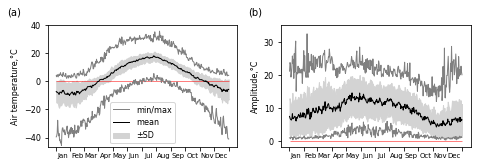

In [56]:
files = ("meteo_daily_1952-2020_WS1.csv", )

for f in files:
    
    tmp = prepare(os.path.join(work_dir, f))
    tmp = tmp.loc[tmp.index.year > 1966]  # observation timetable was changed starting from Jan 1967
    tmp["DAILY_AMPL"] = tmp["MAX_AIR_TEMP"] - tmp["MIN_AIR_TEMP"]
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(2*wu, 1*hu)
    
    ######################## Daily temperatures:
    df = calc_intra_annual(tmp, "MEAN_AIR_TEMP", min_col="MIN_AIR_TEMP", max_col="MAX_AIR_TEMP")
    plot_intra_annual(df, ax1)
    ax1.hlines(y=0, xmin=1, xmax=365, linewidth=0.5, color='r')
    ax1.set_ylim([-47, +40])
    # ax1.set_xlabel("Day of year")
    monthly_ticks(ax1, crop=True)
    ax1.set_ylabel("Air temperature,°C")

    ######################## Daily amplitudes:
    df = calc_intra_annual(tmp, "DAILY_AMPL")
    plot_intra_annual(df, ax2)
    
    ax2.hlines(y=0, xmin=1, xmax=365, linewidth=0.5, color='r')
    ax2.set_ylim([-2, +35])
    # ax2.set_xlabel("Day of year")
    monthly_ticks(ax2, crop=True)
    ax2.set_ylabel("Amplitude,°C")
    
    ax1.text(-0.14, 1.15, "(a)", transform=ax1.transAxes, fontsize=MEDIUM_SIZE, va='top', ha='right')
    ax2.text(-0.1, 1.15, "(b)", transform=ax2.transAxes, fontsize=MEDIUM_SIZE, va='top', ha='right')
    
    ax1.legend()
    #ax2.legend(ncol=3)
    fig.tight_layout()
    
    fig_path = os.path.join(fig_dir, "fig_05.png")
    plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")



#### trends:

<ipython-input-6-b365a3d08e55>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer["HYDRO_YEAR"] = (summer.index.year - 1).astype(str) + "/" + summer.index.year.astype(str)
<ipython-input-6-b365a3d08e55>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter["HYDRO_YEAR"] = (winter.index.year - 1).astype(str) + "/" + winter.index.year.astype(str)


Trend for summer:  
0.01951 x - 23.29
Trend for winter:  
0.1123 x - 231.4


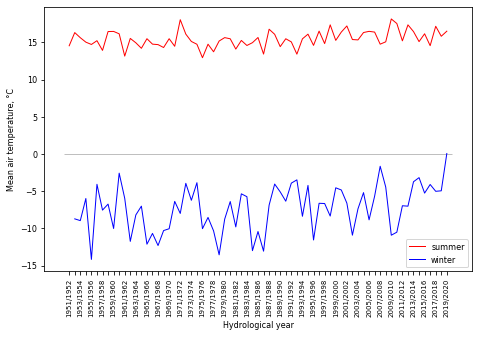

In [6]:
files = ("meteo_daily_1952-2020_WS1.csv", )

tmp = prepare(os.path.join(work_dir, f))

fig, ax = plt.subplots()
fig.set_size_inches(2*wu, 2*hu)

def plot_row(tmp, ax, start, end):
    df = tmp.loc[(tmp.index.year >= start) & (tmp.index.year <= end)]

    df["PDD"] = df["MEAN_AIR_TEMP"].clip(lower=0)  # for positive degree-day sums
    df["NDD"] = df["MEAN_AIR_TEMP"].clip(upper=0)  # for negative degree-day sums
    df["NDD"] = abs(df["NDD"])

    df = df.resample("M").sum()
    df = df.shift(SHIFT)
    df = df.resample("A").sum()
    df["HYDRO_YEAR"] = (df.index.year - 1).astype(str) + "/" + df.index.year.astype(str)
    df = df.iloc[1:]  # since first hydro year is truncated (there is no Oct-Dec of 1966 in dataset)
    # print(df)

    # ax.set_xlim([0, len(df["HYDRO_YEAR"])])
    # ax.set_ylim([-0.05, 0.5])
    ax.plot(df["HYDRO_YEAR"], df["PDD"], color="k", linewidth=1, label="positive")
    ax.plot(df["HYDRO_YEAR"], df["NDD"], color="grey", linewidth=1, label="abs(negative)")
    ax.set_ylabel("Degree-day sum, °C×day")
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

    
def plot_degree(tmp, ax, start, end):
    df = tmp.loc[(tmp.index.year >= start) & (tmp.index.year <= end)]
    # display(df)
    df = df.resample("M").agg({"MEAN_AIR_TEMP": np.mean})
    df = df.shift()  # so the calendar year will start with the previous Dec, needed for resampling by Q
    df = df.resample("Q").agg({"MEAN_AIR_TEMP": np.mean})  # 1st Q is the winter, 3rd Q is the summer
    # display(df)
    summer = df.loc[df.index.month == 9]
    summer["HYDRO_YEAR"] = (summer.index.year - 1).astype(str) + "/" + summer.index.year.astype(str)
    
    fit = np.polyfit(summer.index.year, summer["MEAN_AIR_TEMP"], 1)
    fit_fn = np.poly1d(fit)
    print("Trend for summer:", fit_fn)
    
    winter = df.loc[df.index.month == 3]
    winter["HYDRO_YEAR"] = (winter.index.year - 1).astype(str) + "/" + winter.index.year.astype(str)
    # winter["roll"] = winter["MEAN_AIR_TEMP"].rolling(11, center=True).mean()
    winter = winter.loc[winter.index.year > 1952]  # since first hydro year is truncated: Dec 1951 was not observed
    # display(winter)
    # ax.set_xlim([0, len(df["HYDRO_YEAR"])])
    # ax.set_ylim([-0.05, 0.5])
    ax.plot(summer["HYDRO_YEAR"], summer["MEAN_AIR_TEMP"], color="r", linewidth=1, label="summer")
    ax.plot(winter["HYDRO_YEAR"], winter["MEAN_AIR_TEMP"], color="b", linewidth=1, label="winter")
    # ax.plot(winter["HYDRO_YEAR"], winter["roll"], color="k", linewidth=1, label="winter")
    ax.hlines(y=0, xmin=-1, xmax=69, linewidth=0.5, color='grey')
    ax.set_ylabel("Mean air temperature, °C")
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    winter = winter.loc[winter.index.year >= 1976]
    fit = np.polyfit(winter.index.year, winter["MEAN_AIR_TEMP"], 1)
    fit_fn = np.poly1d(fit)
    print("Trend for winter:", fit_fn)
    
# plot_row(tmp, ax1, 1950, 1966) # observation timetable was changed starting from Jan1967
# plot_row(tmp, ax2, 1967, 2021) # the next part of the time series
# plot_row(tmp, ax, 1950, 2021)
plot_degree(tmp, ax, 1950, 2021)

ax.legend()

ax.set_xlabel("Hydrological year")

for tick in ax.get_xticklabels()[1::2]:
    tick.set_visible(False)

fig.tight_layout()   

fig_path = os.path.join(fig_dir, "fig_06.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")


### Precipitation

#### monthly averaged:

<ipython-input-7-e70391e36651>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["P_LIQUID"] = np.where(df["SOLID"] == 0, df["PRECIPITATION"], np.nan)
<ipython-input-7-e70391e36651>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["P_SOLID"] = np.where(df["SOLID"] == 1, df["PRECIPITATION"], np.nan)


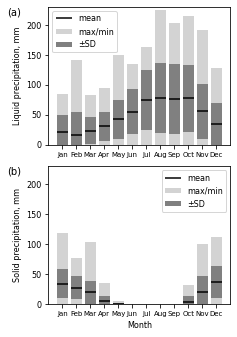

In [7]:
f = "precipitation_daily_1952-2020.csv"

tmp = prepare(os.path.join(work_dir, f))

df = tmp.loc[tmp["GAUGE_NO"] == "P1"]  # the longest time series

df["P_LIQUID"] = np.where(df["SOLID"] == 0, df["PRECIPITATION"], np.nan)
df["P_SOLID"] = np.where(df["SOLID"] == 1, df["PRECIPITATION"], np.nan)
df = df.resample('M').sum()
df["MONTH"] = df.index.month

mean = df.groupby(["MONTH"]).mean()
# print(mean)
std = df.groupby(["MONTH"]).std()
# print(std)
max_df = df.groupby(["MONTH"]).max()
# print(max_df)
min_df = df.groupby(["MONTH"]).min()  # contains zeroes only, useless
# print(min_df)
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(1*wu, 2*hu)


def bar_prec(ax, mean, std, max_df, col_name):
    upper_list = mean + std
    lower_list = mean - std
    lower_list = lower_list.clip(lower=0)
    mean.loc[mean[col_name]== 0] = np.nan
    
    bottoms = (mean[col_name] - std[col_name])
    bottoms = bottoms.clip(lower=0)
    
    bars = ax.bar(max_df.index, max_df[col_name], color="lightgrey", label="max/min")
    # ax.bar(std.index, std[col_name] * 2, bottom=(mean[col_name] - std[col_name]), color="grey", label="±SD")
    ax.bar(std.index, std[col_name] * 2, bottom=bottoms, color="grey", label="±SD")
    x_start = np.array([plt.getp(item, 'x') for item in bars])
    x_end   = x_start + [plt.getp(item, 'width') for item in bars]
    ax.hlines(mean[col_name], x_start, x_end, color="k", label="mean")
    

# plot_prec(ax[0], mean, std, max_df, "P_LIQUID")
# plot_prec(ax[1], mean, std, max_df, "P_SOLID")
bar_prec(ax[0], mean, std, max_df, "P_LIQUID")
bar_prec(ax[1], mean, std, max_df, "P_SOLID")

ax[-1].set_xlabel("Month")
months = ("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")
for a in ax:
    plt.sca(a)
    plt.xticks(np.linspace(1, 12, num=len(months)), months)

ax[0].legend()
ax[1].legend()
ax[0].set_ylabel("Liquid precipitation, mm")
ax[1].set_ylabel("Solid precipitation, mm")
ax[0].set_ylim(0, 230)
ax[1].set_ylim(0, 230)
mark_axes(ax, py=1.0, px=-0.15)

fig.tight_layout()

fig_path = os.path.join(fig_dir, "fig_07.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

#### inter-annual:

Trend for total precip-n:  
3.443 x - 5984
Trend for S/P ratio:  
-0.001422 x + 3.039


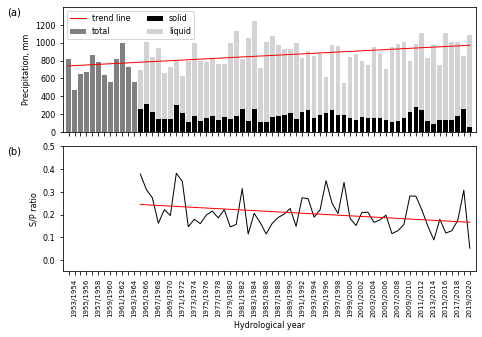

In [43]:
pd.options.mode.chained_assignment = None  # default='warn'

f = "precipitation_daily_1952-2020.csv"

tmp = prepare(os.path.join(work_dir, f))

df = tmp.loc[tmp["GAUGE_NO"] == "P1"]

df["P_TOTAL"] = df["PRECIPITATION"]
df["P_LIQUID"] = np.where(df["SOLID"] == 0, df["PRECIPITATION"], np.nan)
df["P_SOLID"] = np.where(df["SOLID"] == 1, df["PRECIPITATION"], np.nan)
df = df.resample('M').sum()
# print(df)

# Shifting all the columns to obtain hydrological years instead of calendar:
df["P_TOTAL"] = df["P_TOTAL"].shift(SHIFT)
df["P_LIQUID"] = df["P_LIQUID"].shift(SHIFT)
df["P_SOLID"] = df["P_SOLID"].shift(SHIFT)
# print(df)

df = df.resample('Y').sum()
df["HYDRO_YEAR"] = (df.index.year - 1).astype(str) + "/" + df.index.year.astype(str)
df = df.iloc[1:]  # since first hydro year is truncated (there is no Oct-Dec of 1951 in dataset)

df.loc[df["P_LIQUID"] == 0, "P_LIQUID"] = np.nan
df.loc[df["P_SOLID"] == 0, "P_SOLID"] = np.nan

df["SP"] = df["P_SOLID"] / df["P_TOTAL"]  # S/P ratio
df.loc[df["SP"] == 0, "SP"] = np.nan

fig, ax = plt.subplots(2, 1)
fig.set_size_inches(2*wu, 2*hu)

ax[0].set_xlim([-1, len(df["HYDRO_YEAR"])])
# display(df)

# precipitation form is being recorded since Jan 1964
# therefore the hydro year 1963/1964 is not "complete" and should be ommitted:
df.loc[df["HYDRO_YEAR"] == "1963/1964", "P_SOLID"] = np.nan
df.loc[df["HYDRO_YEAR"] == "1963/1964", "P_LIQUID"] = np.nan
df.loc[df["HYDRO_YEAR"] == "1963/1964", "SP"] = np.nan


ax[0].bar(df["HYDRO_YEAR"], df["P_TOTAL"], color="grey", linewidth=1, label="total")
ax[0].bar(df["HYDRO_YEAR"], df["P_SOLID"], color="k", linewidth=1, label="solid")
df["P_SOLID"].loc[pd.isna(df["P_SOLID"])] = 0  # without this "bottom" parameter won't work
ax[0].bar(df["HYDRO_YEAR"], df["P_LIQUID"], bottom=df["P_SOLID"], color="lightgrey", linewidth=1, label="liquid")

#
fit = np.polyfit(df.index.year, df["P_TOTAL"], 1)
fit_fn = np.poly1d(fit)
print("Trend for total precip-n:", fit_fn)
df["predicted"] = df.index.year * fit[0] + fit[1]
# display(df["predicted"])
ax[0].plot(df["HYDRO_YEAR"], df["predicted"], color="r", linewidth=1, label="trend line")
#

ax[0].set_ylabel("Precipitation, mm")
ax[0].set_ylim(0, 1399)
ax[0].legend(loc=2, ncol=2)

ax[1].set_xlim([-1, len(df["HYDRO_YEAR"])])
ax[1].set_ylim([-0.05, 0.5])
ax[1].plot(df["HYDRO_YEAR"], df["SP"], color="k", linewidth=1)
ax[1].set_ylabel("S/P ratio")

#
df.dropna(inplace=True)
fit = np.polyfit(df.index.year, df["SP"], 1)
fit_fn = np.poly1d(fit)
print("Trend for S/P ratio:", fit_fn)
df["predicted"] = df.index.year * fit[0] + fit[1]
# display(df["predicted"])
ax[1].plot(df["HYDRO_YEAR"], df["predicted"], color="r", linewidth=1, label="trend")
#

ax[-1].set_xlabel("Hydrological year")

for a in ax[:1]:
    for tick in a.get_xticklabels()[::1]:
        tick.set_visible(False)
for tick in ax[-1].get_xticklabels():
    tick.set_rotation(90)
for tick in ax[-1].get_xticklabels()[0::2]:
    tick.set_visible(False)

mark_axes(ax, py=1.0)

fig.subplots_adjust(bottom=0.4)
fig.tight_layout()

fig_path = os.path.join(fig_dir, "fig_08.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

### Snow surveys

<ipython-input-44-a2aabdfd5787>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(("Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul"), minor=True)  # dirty but quick


Trend eqn:  
-0.5189 x + 1106
Trend eqn:  
-1.255 x + 2663


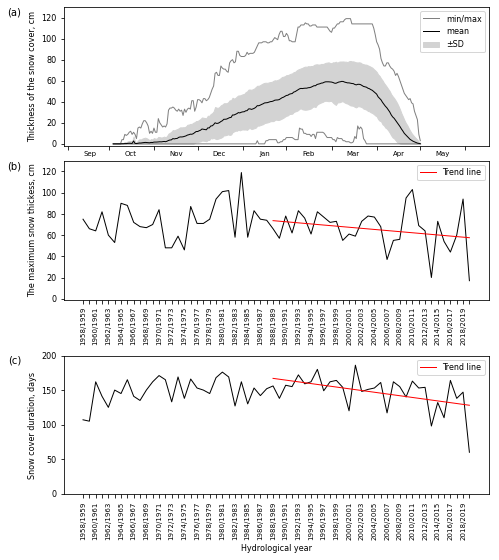

In [44]:
f = "meteo_daily_1952-2020_WS1.csv"

SHIFT = 2  # to start the hydrological year in November

fig, ax = plt.subplots(3, 1)
fig.set_size_inches(2*wu, 3*hu)

tmp = prepare(os.path.join(work_dir, f))

################### Thickness of the snow cover:
df = calc_intra_annual(tmp, "SNOW_THICKNESS")

old_index = df.index
df = df.reindex(index=np.roll(df.index, 153))  # now df begins at the 1st Aug
df.index = old_index  # but the plotting function shouldn't know this
# display(df)

plot_intra_annual(df, ax[0])
ax[0].set_ylim(-2, 130)
ax[0].set_xlim(28, 320)
    
# ax[0].set_xlabel("Day of year")
monthly_ticks(ax[0], crop=False)
ax[0].set_xticklabels(("Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul"), minor=True)  # dirty but quick
ax[0].set_ylabel("Thickness of the snow cover, cm")
ax[0].legend()

################### Max snow cover thickness during the spring:
df = tmp.loc[tmp.index.month < 6]
df = df.resample("A")["SNOW_THICKNESS"].agg(["max"])
df["YEAR"] = df.index.year
# df = df.loc[df["YEAR"] > 1985]
df.dropna(inplace=True)
# print("LENGTH", len(df.index))
df["HYDRO_YEAR"] = (df.index.year - 1).astype(str) + "/" + df.index.year.astype(str)
df = df.iloc[2:]  # 1956/1957 is not available, observation started only from Jan 1957; 1957/58 is not complete

ax[1].plot(df["HYDRO_YEAR"], df["max"], color="k", linewidth=1)

df = df.loc[df["YEAR"] > 1988]
df.dropna(inplace=True)
fit = np.polyfit(df["YEAR"], df["max"], 1)
fit_fn = np.poly1d(fit)
print("Trend eqn:", fit_fn)
df["predicted"] = df["YEAR"] * fit[0] + fit[1]

ax[1].plot(df["HYDRO_YEAR"], df["predicted"], color="r", linewidth=1, label="Trend line")
ax[1].set_ylabel("The maximum snow thickess, cm")
ax[1].set_ylim([-1, 130])
# ax2.set_xlim([0, len(df["HYDRO_YEAR"])])

################### Days with the snow cover:
df = tmp
df["DAY"] = np.where(df["SNOW_THICKNESS"] > 0, 1, 0)

df = df.resample("M")["DAY"].agg(["sum"])
df["DAY_SHIFT"] = df["sum"].shift(SHIFT)

df = df.resample("A")["DAY_SHIFT"].agg(["sum"])
df["sum"] = np.where(df["sum"] == 0, np.nan, df["sum"])
df["HYDRO_YEAR"] = (df.index.year - 1).astype(str) + "/" + df.index.year.astype(str)
df = df.iloc[7:]
# print("LENGTH", len(df.index))

ax[2].plot(df["HYDRO_YEAR"], df["sum"], color="k", linewidth=1)
ax[2].set_xlabel("Hydrological year")
ax[2].set_ylabel("Snow cover duration, days")
# ax3.set_xlim([0, len(df["HYDRO_YEAR"])])
ax[2].set_ylim([-1, 200])

# trend line for snow cover duration:
df["YEAR"] = df.index.year
df = df.loc[df["YEAR"] > 1988]
df.dropna(inplace=True)
fit = np.polyfit(df["YEAR"], df["sum"], 1)
fit_fn = np.poly1d(fit)
print("Trend eqn:", fit_fn)
df["predicted"] = df["YEAR"] * fit[0] + fit[1]
ax[2].plot(df["HYDRO_YEAR"], df["predicted"], color="r", linewidth=1, label="Trend line")

fig.tight_layout()

for a in (ax[1], ax[2]):
    for tick in a.get_xticklabels():
        tick.set_rotation(90)
    for tick in a.get_xticklabels()[1::2]:
        tick.set_visible(False)
    a.legend()

pos = ax[1].get_position()
pts = pos.get_points()
pts[0][1] += 0.02
pts[1][1] += 0.02
pos.set_points(pts)
ax[1].set_position(pos)

pos = ax[2].get_position()
pts = pos.get_points()
pts[0][1] -= 0.04
pts[1][1] -= 0.04
pos.set_points(pts)
ax[2].set_position(pos)

mark_axes(ax, px=-0.10, py=1.00)

fig_path = os.path.join(fig_dir, "fig_09.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white", bbox_inches="tight")

### Peat temperatures (old)

Trend slope for the surface: 0.65°C/decade
Trend slope for the depth of 320 cm: 0.23°C/decade


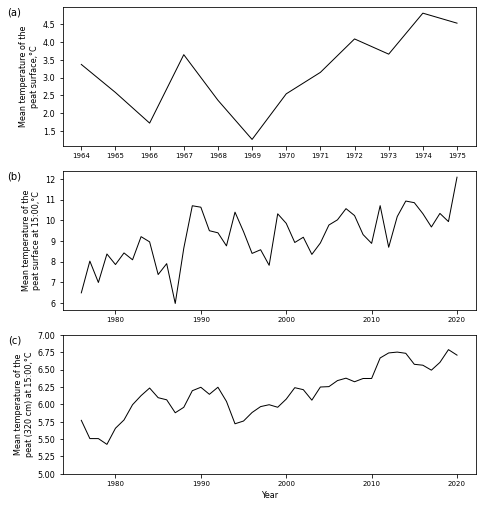

In [10]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(2*wu, 3*hu)

##### Daily series:
f = "peat-temp_daily_1954-2020.csv"

tmp = prepare(os.path.join(work_dir, f))

tmp = tmp.loc[tmp["QC"] != 0]
tmp = tmp.loc[tmp["DEPTH"] == 0]
tmp = tmp.loc[tmp["OBS_TYPE"] == "avg"]
tmp = tmp.loc[tmp.index.year < 1976]  # 1976 is non-complete

for site in ("PT1", ):  # site 2 was observed only during summertime, we won't use it
    df = tmp.loc[tmp["SITE"] == site]
    df = df.resample("A")["PEAT_TEMP"].agg(["mean"])
    # print(df)
    ax[0].plot(df.index.year, df["mean"], color="k", linewidth=1, label="Site %s" % site)
    ax[0].xaxis.set_ticks(np.arange(df.index.year.min(), df.index.year.max()+1, 1))

ax[0].set_ylabel("Mean temperature of the\npeat surface,°C")
    
##### "Hourly" series:

f = "peat-temp_hourly_1976-2020.csv"

tmp = prepare(os.path.join(work_dir, f))

tmp = tmp.loc[tmp["QC"] != 0]
tmp = tmp.loc[tmp.index.hour == 15]
tmp = tmp.loc[tmp["SITE"] == "PT1"]

# PEAT SURFACE
df = tmp.loc[tmp["DEPTH"] == 0]
# print(df)
df = df.resample("A")["PEAT_TEMP"].agg(["mean", "max"])
# print(df)
ax[1].plot(df.index.year, df["mean"], color="k", linewidth=1)
# ax.plot(df.index.year, df["max"], color="k", linewidth=1, label="Site %s" % site)
ax[1].set_ylabel("Mean temperature of the\npeat surface at 15:00,°C")

fit = np.polyfit(df.index.year, df["mean"], 1)
# fit_fn = np.poly1d(fit)
print("Trend slope for the surface: %s°C/decade" % round(fit[0] * 10, 2))

# max available depth - 320 cm
df = tmp.loc[tmp["DEPTH"] == 320]
df = df.resample("A")["PEAT_TEMP"].agg(["mean"])
ax[2].plot(df.index.year, df["mean"], color="k", linewidth=1)
ax[2].set_ylabel("Mean temperature of the\npeat (320 cm) at 15:00,°C")
ax[2].set_ylim([5, 7])

fit = np.polyfit(df.index.year, df["mean"], 1)
# fit_fn = np.poly1d(fit)
print("Trend slope for the depth of 320 cm: %s°C/decade" % round(fit[0] * 10, 2))
# 
mark_axes(ax, px=-0.1, py=1)
ax[-1].set_xlabel("Year")

fig.tight_layout()

fig_path = os.path.join(fig_dir, "fig_10.png")
# plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

^^^ let's merge panels with 0 and 320 cm depths

### Peat temperatures (new, use this):

Trend slope for the surface: 0.65°C/decade
Trend slope for the depth of 320 cm: 0.23°C/decade


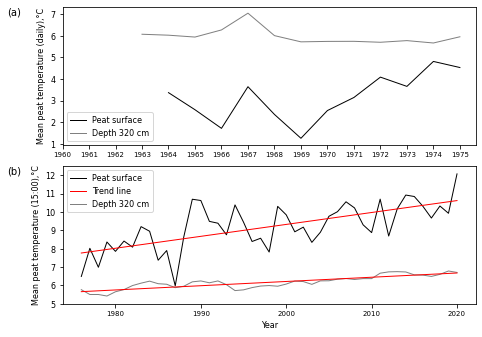

In [53]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(2*wu, 2*hu)

##### Daily series:
f = "peat-temp_daily_1954-2020.csv"

tmp = prepare(os.path.join(work_dir, f))

tmp = tmp.loc[tmp["QC"] != 0]
# tmp = tmp.loc[tmp["DEPTH"] == 0]
tmp = tmp.loc[tmp["OBS_TYPE"] == "avg"]
tmp = tmp.loc[tmp.index.year < 1976]  # 1976 is non-complete

for site in ("PT1", ):  # site 2 was observed only during summertime, we won't use it
    df = tmp.loc[tmp["SITE"] == site]

    df_surf = df.loc[df["DEPTH"] == 0]
    df_surf = df_surf.resample("A")["PEAT_TEMP"].agg(["mean"])
    ax[0].plot(df_surf.index.year, df_surf["mean"], color="k", linewidth=1, label="Peat surface")
    
    df_320 = df.loc[df["DEPTH"] == 320]
    df_320 = df_320.resample("A")["PEAT_TEMP"].agg(["mean"])
    ax[0].plot(df_320.index.year, df_320["mean"], color="grey", linewidth=1, label="Depth 320 cm")
    
ax[0].xaxis.set_ticks(np.arange(df.index.year.min(), df.index.year.max()+1, 1))
ax[0].set_ylabel("Mean peat temperature (daily),°C")
# ax[0].set_ylim([1, 5])
ax[0].legend()
    
##### "Hourly" series:

f = "peat-temp_hourly_1976-2020.csv"

tmp = prepare(os.path.join(work_dir, f))

tmp = tmp.loc[tmp["QC"] != 0]
tmp = tmp.loc[tmp.index.hour == 15]
tmp = tmp.loc[tmp["SITE"] == "PT1"]

# PEAT SURFACE
df = tmp.loc[tmp["DEPTH"] == 0]
# print(df)
df = df.resample("A")["PEAT_TEMP"].agg(["mean", "max"])
# print(df)
ax[1].plot(df.index.year, df["mean"], color="k", linewidth=1, label="Peat surface")
# ax.plot(df.index.year, df["max"], color="k", linewidth=1, label="Site %s" % site)


fit = np.polyfit(df.index.year, df["mean"], 1)
print("Trend slope for the surface: %s°C/decade" % round(fit[0] * 10, 2))
fit_fn = np.poly1d(fit)
df["predicted"] = df.index.year * fit[0] + fit[1]
ax[1].plot(df.index.year, df["predicted"], color="r", linewidth=1, label="Trend line")

# max available depth - 320 cm
df = tmp.loc[tmp["DEPTH"] == 320]
df = df.resample("A")["PEAT_TEMP"].agg(["mean"])
ax[1].plot(df.index.year, df["mean"], color="grey", linewidth=1, label="Depth 320 cm")

fit = np.polyfit(df.index.year, df["mean"], 1)
print("Trend slope for the depth of 320 cm: %s°C/decade" % round(fit[0] * 10, 2))
fit_fn = np.poly1d(fit)
df["predicted"] = df.index.year * fit[0] + fit[1]
ax[1].plot(df.index.year, df["predicted"], color="r", linewidth=1)

ax[1].set_ylabel("Mean peat temperature (15:00),°C")
ax[1].set_ylim([5, 12.5])
ax[1].legend()
# 
mark_axes(ax, px=-0.1, py=1)
ax[-1].set_xlabel("Year")

fig.tight_layout()

fig_path = os.path.join(fig_dir, "fig_10.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

### Freezing of the peat surface

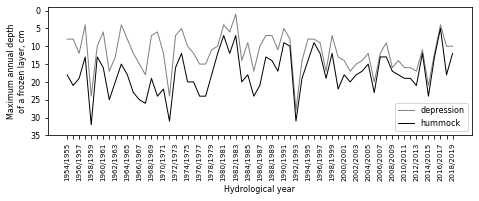

In [12]:
f = "swamp-freezing_10d_1954-2020.csv"

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2*wu, 1.2*hu)

tmp = prepare(os.path.join(work_dir, f))
tmp.sort_index(inplace=True)
# tmp.info()

for t, label, color in zip((0, 1), ("depression", "hummock"), ("grey", "k")):
    df = tmp.loc[(tmp["SITE"] == "SF1") & (tmp["TERRAIN"] == t)]
    df = df.resample("AS-NOV")["FROZEN"].agg(["max"])
    df = df.loc[df.index.year > 1954]  # first year of observations (1954) is incomplete
    df["HYDRO_YEAR"] = (df.index.year - 1).astype(str) + "/" + df.index.year.astype(str)
    # display(df)
    
    ax.plot(df["HYDRO_YEAR"], df["max"], color=color, linewidth=1, label=label)

ax.set_ylabel("Maximum annual depth\nof a frozen layer, cm")
ax.set_xlabel("Hydrological year")
ax.set_ylim([-1, 35])
ax.legend()
ax.invert_yaxis()

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
for tick in ax.get_xticklabels()[1::2]:
    tick.set_visible(False)

fig.tight_layout()

fig_path = os.path.join(fig_dir, "fig_11.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

### Evapotranspiration

<ipython-input-13-f1116b0fafc7>:68: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax1.set_xticks(np.linspace(9, 33, num=len(months)), months)


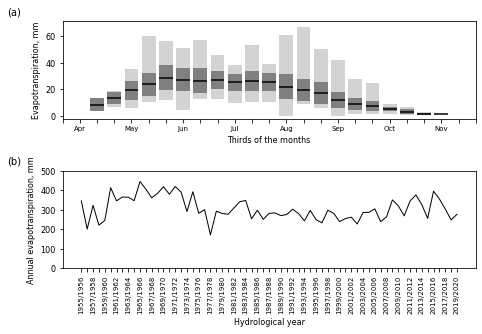

In [13]:
f = "evapotranspiration_10d_1956-2020.csv"

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(2*wu, 2*hu)

tmp = prepare(os.path.join(work_dir, f))

df = tmp.loc[tmp["SITE"] == "ET1"]  # the longest time series

# INTRA_ANNUAL VARIABILITY:

df["MONTH"] = df.index.month
# getting the number of a 10-day period of a month:
df["D"] = 1
df.loc[df.index.day > 10, "D"] = 2
df.loc[df.index.day > 20, "D"] = 3
df["10d"] = (df["MONTH"] - 1) * 3 + df["D"]  # number of a 10-day period within a year
# print(df)

mean_list = []
std_list = []
max_list = []
min_list = []
day_list = []

for i in range(1, 37):  # there are 36 10-day period in a year
    df_d = df.loc[df["10d"] == i]
    
    if not df_d.empty:
        # print(df_d)
        mean_et = df_d["ET"].mean()
        std_et = df_d["ET"].std()
        max_et = df_d["ET"].max()
        min_et = df_d["ET"].min()
    else:
        mean_et = np.nan
        std_et = np.nan
        max_et = np.nan
        min_et = np.nan
        
    mean_list.append(mean_et)
    std_list.append(std_et)
    max_list.append(max_et)
    min_list.append(min_et)
    day_list.append(i)

upper_list = [sum(x) for x in zip(mean_list, std_list)]
lower_list = [x[0] - x[1] for x in zip(mean_list, std_list)]

min_list = np.where(pd.isna(min_list), 0, min_list)
bars = ax1.bar(day_list, [a_i - b_i for a_i, b_i in zip(max_list, min_list)], bottom=min_list, color="lightgrey", label="max/min")
tops = [x * 2 for x in std_list]
tops = [a_i if a_i < b_i else b_i for a_i, b_i in zip(tops, max_list)]  # ensures that mean+SD will always by < than max value
bottoms = [a_i - b_i for a_i, b_i in zip(mean_list, std_list)]
bottoms = np.where(pd.isna(bottoms), 0, bottoms)

ax1.bar(day_list, tops, bottom=bottoms, color="grey", label="±SD")
x_start = np.array([plt.getp(item, 'x') for item in bars])
x_end   = x_start + [plt.getp(item, 'width') for item in bars]
ax1.hlines(mean_list, x_start, x_end, color="k", label="mean")
ax1.set_ylim([-2, 71])

ax1.set_xlim([9, 33])
ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
months = ["", 'Apr', "", "", 'May', "", "", 'Jun',"", "",  'Jul',"", "",  'Aug',"", "",  'Sep',"", "",  'Oct',"", "",  'Nov', "", ""]
plt.sca(ax1)
plt.xticks(np.linspace(9, 33, num=len(months)), months)
ax1.set_xticks(np.linspace(9, 33, num=len(months)), months)

ax1.set_xlabel("Thirds of the months")
ax1.set_ylabel("Evapotranspiration, mm")
# ax1.text(-0.14, 1.15, "(a)", transform=ax1.transAxes, fontsize=MEDIUM_SIZE, va='top', ha='right')    

# INTER-ANNUAL VARIABILITY:
df = df.resample("A")["ET"].agg(["sum"])

df["HYDRO_YEAR"] = (df.index.year - 1).astype(str) + "/" + df.index.year.astype(str)
# print(df)

ax2.plot(df["HYDRO_YEAR"], df["sum"], color="k", linewidth=1)
ax2.set_ylim([-2, 500])
ax2.set_xlabel("Hydrological year")
ax2.set_ylabel("Annual evapotranspiration, mm")
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
for tick in ax2.get_xticklabels()[1::2]:
    tick.set_visible(False)

mark_axes((ax1, ax2))

fig.tight_layout()

fig_path = os.path.join(fig_dir, "fig_13.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")


### Runoff

#### Data availability:

<ipython-input-14-63cc96ffe06b>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels);


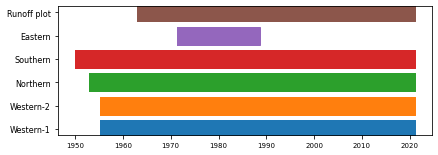

In [14]:
f = "water-discharge_daily_1950-2020.csv"

fig, ax = plt.subplots()
fig.set_size_inches(2*wu, 1*hu)

df = prepare(os.path.join(work_dir, f))

width = 1
height = 100
verts = list(zip([-width,width,width,-width],[-height,-height,height,height]))

sites = df["SITE"].unique()
i = 1
df["id"] = np.nan
for s in sites:
    df["id"] = np.where(df["SITE"] == s, i, df["id"])
    ax.scatter(df.loc[df["id"] == i].index, df.loc[df["id"] == i]["id"], marker=verts, s=350)
    i += 1

labels = ["",]
labels += list(sites)
ax.set_yticklabels(labels);


The conclusion is that we could sum the discharge from the W1, W2, N and S streams since 1955 until present, computing the total annual drainage amount for the peatland.

#### Annual runoff amounts:

Trend eqn:  
1.325 x - 2259


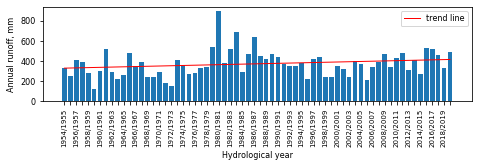

In [41]:
f = "water-discharge_daily_1950-2020.csv"

# watershed areas are: 1.18, 0.32, 0.37, 0.10 sq. km for S, W1+W2, N, E
basin_area = 1.18 + 0.32 + 0.37 + 0.10

fig, ax = plt.subplots()
fig.set_size_inches(2*wu, 1*hu)

df = prepare(os.path.join(work_dir, f))

df = df.loc[df["SITE"].isin(("Western-1", "Western-2", "Northern", "Southern"))]
df = df.loc[df.index.year >= 1955]

df["VOLUME"] = df["DISCHARGE"] * 86400 / 1000000  # cubic cm -> cubic m

df = df.resample("AS-NOV").agg("sum")
df["HYDRO_YEAR"] = df.index.year.astype(str) + "/" + (df.index.year + 1).astype(str)
df = df.loc[df.index.year < 2020]
# display(df)

ax.bar(df["HYDRO_YEAR"], df["VOLUME"] / 1000 / basin_area);
ax.set_xlabel("Hydrological year")
ax.set_ylabel("Annual runoff, mm")

# trend line for snow cover duration:
df["YEAR"] = df.index.year
fit = np.polyfit(df["YEAR"], df["VOLUME"] / 1000 / basin_area, 1)
fit_fn = np.poly1d(fit)
print("Trend eqn:", fit_fn)
df["predicted"] = df["YEAR"] * fit[0] + fit[1]
ax.plot(df["HYDRO_YEAR"], df["predicted"], color="r", linewidth=1, label="trend line")

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
for tick in ax.get_xticklabels()[1::2]:
    tick.set_visible(False)
ax.legend()

plt.tight_layout()
fig_path = os.path.join(fig_dir, "fig_15.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

#### Intra-annual example from a large stream:

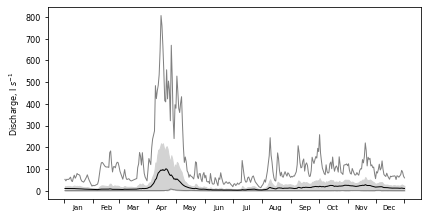

In [16]:
f = "water-discharge_daily_1950-2020.csv"

fig, ax = plt.subplots()
fig.set_size_inches(2*wu, 1.5*hu)

tmp = prepare(os.path.join(work_dir, f))
tmp = tmp.loc[tmp["SITE"] == "Southern"]
tmp["DISCHARGE"] = tmp["DISCHARGE"] / 1000

df = calc_intra_annual(tmp, "DISCHARGE")
plot_intra_annual(df, ax)
# ax.set_ylim([-2, 500])

monthly_ticks(ax, crop=True)
ax.set_ylabel("Discharge, l $s^{-1}$")
# ax.legend()

fig_path = os.path.join(fig_dir, "fig_14.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

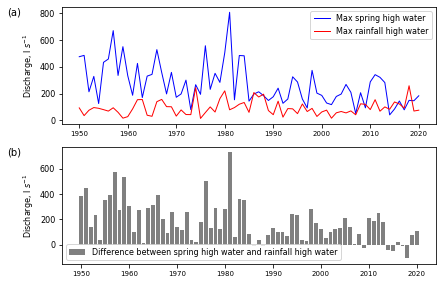

In [17]:
f = "water-discharge_daily_1950-2020.csv"

fig, ax = plt.subplots(2, 1)
fig.set_size_inches(2*wu, 2*hu)

tmp = prepare(os.path.join(work_dir, f))
tmp.sort_index(inplace=True)

tmp = tmp.loc[tmp["SITE"] == "Southern"]
tmp["DISCHARGE"] = tmp["DISCHARGE"] / 1000

# spring max discharges:
df = tmp.loc[(tmp.index.dayofyear >= 50) & (tmp.index.dayofyear < 135)] 
# print(df)
max_df = df.groupby(df.index.year).max()
# print(max_df)
ax[0].plot(max_df.index, max_df["DISCHARGE"], color="b", linewidth=1, label="Max spring high water")

# max summer discharges:
df = tmp.loc[tmp.index.dayofyear >= 135]
rain_df = df.groupby(df.index.year).max()
ax[0].plot(rain_df.index, rain_df["DISCHARGE"], color="r", linewidth=1, label="Max rainfall high water")

diff = max_df["DISCHARGE"] - rain_df["DISCHARGE"]
ax[1].bar(rain_df.index, diff, color="grey", linewidth=1, label="Difference between spring high water and rainfall high water")

ax[0].set_ylabel("Discharge, l $s^{-1}$")
ax[1].set_ylabel("Discharge, l $s^{-1}$")

ax[0].legend()
ax[1].legend(loc=3)

mark_axes(ax, px=-0.11, py=1)

fig_path = os.path.join(fig_dir, "fig_16.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

### Groundwater temperature

#### Trend in the averaged temperature (old style):

All the gw-wells in the dataset: ['G359', 'G360', 'G362', 'G364', 'G365', 'G366', 'G367', 'G369', 'G374', 'G375', 'G376', 'G377', 'G378', 'G379', 'G386', 'G387', 'G388', 'G389', 'G390']
Well #G359 - 1661 observations
Well #G360 - 1656 observations
Well #G362 - 317 observations
Well #G364 - 1647 observations
Well #G365 - 1661 observations
Well #G366 - 1661 observations
Well #G367 - 1661 observations
Well #G369 - 1639 observations
Well #G374 - 1639 observations
Well #G375 - 1661 observations
Well #G376 - 1661 observations
Well #G377 - 1661 observations
Well #G378 - 1526 observations
Well #G379 - 1661 observations
Well #G386 - 386 observations
Well #G387 - 409 observations
Well #G388 - 409 observations
Well #G389 - 409 observations
Well #G390 - 403 observations
['G359', 'G365', 'G366', 'G367', 'G375', 'G376', 'G377', 'G379']


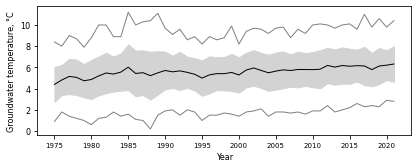

In [18]:
f = "groundwater-temp_daily_1974-2020.csv"

fig, ax = plt.subplots()
fig.set_size_inches(2*wu, 1*hu)

tmp = prepare(os.path.join(work_dir, f))
tmp.sort_index(inplace=True)

wells = sorted(tmp["GW_WELL"].unique())
print("All the gw-wells in the dataset:", wells)
"""
# plots separately all the gw-wells with the longest time series:
for w in wells:
    df = tmp.loc[tmp["GW_WELL"] == w]
    obs_num = len(df.index)
    print("Well #%s - %s observations" % (w, len(df.index)))
    # print(w, df.index[0], df.index[-1])
    df = df.resample("A").mean()
    # print("Well #%s - %s years" % (w, len(df.index)))
    # if len(df.index) >= 46:
    if obs_num >= 1661:
        ax.plot(df.index, df["GW_TEMP"], linewidth=1, label="Well #%s" % w)
ax.legend()
fig.tight_layout()

fig_path = os.path.join(fig_dir, "test_GW_TEMP.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")
"""
longest_series = []
for w in wells:
    df = tmp.loc[tmp["GW_WELL"] == w]
    obs_num = len(df.index)
    print("Well #%s - %s observations" % (w, len(df.index)))
    if obs_num >= 1661:
        longest_series.append(w)
print(longest_series)

df = tmp.loc[tmp["GW_WELL"].isin(longest_series)]
df = df.resample("A")["GW_TEMP"].agg(["mean", "max", "min", "std"])
df["upper"] = df["mean"] + df["std"]
df["lower"] = df["mean"] - df["std"]

plot_intra_annual(df, ax)
ax.set_xlabel("Year")
ax.set_ylabel("Groundwater temperature, °C")

fig_path = os.path.join(fig_dir, "fig_20_old.png")
# plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

^^^ no, the chart above looks like the intraannual plots. We need another style:

#### Trend in the averaged temperature (new style):

['G359', 'G365', 'G366', 'G367', 'G375', 'G376', 'G377', 'G379']
Trend eqn:  
0.02716 x - 48.62


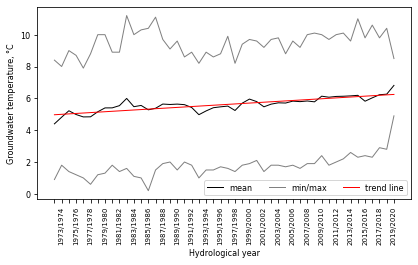

In [42]:
f = "groundwater-temp_daily_1974-2020.csv"

fig, ax = plt.subplots()
fig.set_size_inches(2*wu, 1.5*hu)

tmp = prepare(os.path.join(work_dir, f))
tmp.sort_index(inplace=True)

wells = sorted(tmp["GW_WELL"].unique())
# print("All the gw-wells in the dataset:", wells)

longest_series = []
for w in wells:
    df = tmp.loc[tmp["GW_WELL"] == w]
    obs_num = len(df.index)
    #print("Well #%s - %s observations" % (w, len(df.index)))
    if obs_num >= 1661:
        longest_series.append(w)
print(longest_series)

df = tmp.loc[tmp["GW_WELL"].isin(longest_series)]
df = df.resample("AS-NOV")["GW_TEMP"].agg(["mean", "max", "min", "std"])
df["HYDRO_YEAR"] = (df.index.year - 1).astype(str) + "/" + df.index.year.astype(str)
# df["upper"] = df["mean"] + df["std"]
# df["lower"] = df["mean"] - df["std"]

# plot_intra_annual(df, ax)
ax.plot(df["HYDRO_YEAR"], df["mean"], color="k", linewidth=1, label="mean")
ax.plot(df["HYDRO_YEAR"], df["min"], color="grey", linewidth=1, label="min/max")
ax.plot(df["HYDRO_YEAR"], df["max"], color="grey", linewidth=1)
ax.set_xlabel("Hydrological year")
ax.set_ylabel("Groundwater temperature, °C")

# trend line for snow cover duration:
df["YEAR"] = df.index.year
fit = np.polyfit(df["YEAR"], df["mean"], 1)
fit_fn = np.poly1d(fit)
print("Trend eqn:", fit_fn)
df["predicted"] = df["YEAR"] * fit[0] + fit[1]
ax.plot(df["HYDRO_YEAR"], df["predicted"], color="r", linewidth=1, label="trend line")

ax.legend(loc=4, ncol=3)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
for tick in ax.get_xticklabels()[0::2]:
    tick.set_visible(False)

fig_path = os.path.join(fig_dir, "fig_20.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

#### Intra-annual levels:

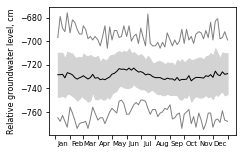

In [19]:
f = "groundwater-level_daily_1964-2020.csv"

fig, ax = plt.subplots()
fig.set_size_inches(1*wu, 1*hu)

tmp = prepare(os.path.join(work_dir, f))
tmp.sort_index(inplace=True)

tmp = tmp.loc[tmp["GW_WELL"] == "G377"]  # this well is located on the dome

# in some years there were daily observations, in some 10-day
# we need only 10-day observation to remain:
tmp["LDAY"] = tmp.index + MonthEnd(0)  # the last day of the month
tmp["DEL"] = ~tmp.index.day.isin((5, 10, 15, 20, 25)) & ~(tmp.index == tmp["LDAY"])
tmp = tmp.loc[~tmp["DEL"]]
# display(tmp)

# next we need to merge 29th Feb with the 28ths
# otherwise it breaks the behaviour of the calc_intra_annual function
tmp.index = np.where((tmp.index.month == 2) & (tmp.index.day == 29), tmp.index - timedelta(days=1), tmp.index)
# display(tmp.loc[(tmp.index.month == 2) & (tmp.index.day > 27)])  # every row should have the index of "YYYY-02-28"

df = calc_intra_annual(tmp, "GW_LEVEL")
plot_intra_annual(df, ax)

ax.set_ylabel("Relative groundwater level, cm")
# ax.set_xlabel("Day of year")
monthly_ticks(ax)

fig_path = os.path.join(fig_dir, "fig_19.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")


### Swamp-water wells:

#### Some statistics first:

In [20]:
f = "swamp-water-level_daily_1950-2020.csv"

tmp = prepare(os.path.join(work_dir, f))
tmp.sort_index(inplace=True)

wells = sorted(tmp["SW_WELL"].unique())
num = len(wells)
print("All the sw-wells in the dataset (%s):" % num, wells)

for w in wells:
    df = tmp.loc[tmp["SW_WELL"] == w]
    obs_num = len(df.index)
    df = df.resample("A").mean()
    print("Well %s - %s years - %s - %s (%s observations)" % (w, len(df.index), df.index.date[0], df.index.date[-1], obs_num))

All the sw-wells in the dataset (23): ['Dve Sestry Lake', 'S101', 'S102', 'S102a', 'S103', 'S104', 'S105', 'S106', 'S107', 'S107a', 'S107b', 'S108', 'S109', 'S210', 'S211', 'S212', 'S313', 'S314', 'S315', 'S316', 'S317', 'S318', 'S319']
Well Dve Sestry Lake - 53 years - 1968-12-31 - 2020-12-31 (5813 observations)
Well S101 - 71 years - 1950-12-31 - 2020-12-31 (15179 observations)
Well S102 - 40 years - 1950-12-31 - 1989-12-31 (13028 observations)
Well S102a - 46 years - 1975-12-31 - 2020-12-31 (4129 observations)
Well S103 - 71 years - 1950-12-31 - 2020-12-31 (15176 observations)
Well S104 - 71 years - 1950-12-31 - 2020-12-31 (21530 observations)
Well S105 - 40 years - 1950-12-31 - 1989-12-31 (12778 observations)
Well S106 - 71 years - 1950-12-31 - 2020-12-31 (14908 observations)
Well S107 - 40 years - 1950-12-31 - 1989-12-31 (8825 observations)
Well S107a - 6 years - 1970-12-31 - 1975-12-31 (849 observations)
Well S107b - 51 years - 1970-12-31 - 2020-12-31 (4401 observations)
Well S10

Longest time series are from the wells: ['S109']


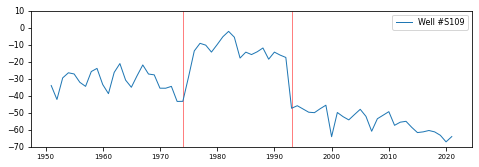

In [21]:
f = "swamp-water-level_daily_1950-2020.csv"

fig, ax = plt.subplots()
fig.set_size_inches(2*wu, 1*hu)

tmp = prepare(os.path.join(work_dir, f))
tmp.sort_index(inplace=True)

wells = sorted(tmp["SW_WELL"].unique())
num = len(wells)

wl = "S109"

longest_series = []
for w in wells:
    df = tmp.loc[tmp["SW_WELL"] == w]
    df = df.resample("A").mean()
    # if len(df.index) == 71:
    if w == wl:
        longest_series.append(w)
        ax.plot(df.index, df["SW_LEVEL"], linewidth=1, label="Well #%s" % w)
print("Longest time series are from the wells:", longest_series)
ax.set_ylim((-70, 10))

ax.vlines(x=pd.to_datetime("1993-01-01"), ymin=-70, ymax=10, linewidth=0.5, color='r')
ax.vlines(x=pd.to_datetime("1974-01-01"), ymin=-70, ymax=10, linewidth=0.5, color='r')

ax.legend()
fig.tight_layout()

fig_path = os.path.join(fig_dir, "test_SW_depth_%s.png" % wl)
# plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")


#### Intra-annual:

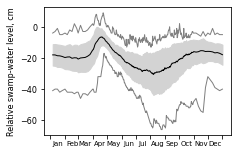

In [22]:
f = "swamp-water-level_daily_1950-2020.csv"

fig, ax = plt.subplots()
fig.set_size_inches(1*wu, 1*hu)

tmp = prepare(os.path.join(work_dir, f))
tmp.sort_index(inplace=True)

wl = "S104"  # reference well

tmp = tmp.loc[tmp["SW_WELL"] == wl]

# the timetable of obervations was floating during the "cold" period
# in some years there were daily observations, in some 5-day
# we need only 5-day observation to remain:
tmp["LDAY"] = tmp.index + MonthEnd(0)  # the last day of the month
tmp["DEL"] = tmp.index.month.isin([1, 2, 3, 11, 12]) & ~tmp.index.day.isin((5, 10, 15, 20, 25)) & ~(tmp.index == tmp["LDAY"])
# display(tmp)
tmp = tmp.loc[~tmp["DEL"]]

# next we need to merge 29th Feb with the 28ths
# otherwise it breaks the behaviour of the calc_intra_annual function
tmp.index = np.where((tmp.index.month == 2) & (tmp.index.day == 29), tmp.index - timedelta(days=1), tmp.index)
# display(tmp.loc[(tmp.index.month == 2) & (tmp.index.day > 27)])


df = calc_intra_annual(tmp, "SW_LEVEL")
# display(df.loc[df.index > 55])
plot_intra_annual(df, ax)

ax.set_ylabel("Relative swamp-water level, cm")
# ax.set_xlabel("Day of year")
monthly_ticks(ax)

fig_path = os.path.join(fig_dir, "fig_17.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

### Surface elevation:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 1965-01-01 to 1995-01-01
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WELL_NO    254 non-null    object 
 1   WELL_TYPE  254 non-null    object 
 2   SURF_ELEV  254 non-null    float64
dtypes: float64(1), object(2)
memory usage: 7.9+ KB
['Dve Sestry Lake', 'G359', 'G360', 'G361', 'G362', 'G363', 'G364', 'G365', 'G366', 'G367', 'G369', 'G374', 'G375', 'G376', 'G377', 'G378', 'G379', 'G386', 'G387', 'G388', 'G389', 'G390', 'S101', 'S102', 'S102a', 'S103', 'S104', 'S105', 'S106', 'S107', 'S107a', 'S107b', 'S108', 'S109', 'S210', 'S211', 'S212', 'S313', 'S314', 'S315', 'S316', 'S317', 'S318', 'S319']
44
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7 entries, 1965-01-01 to 1995-01-01
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WELL_NO    7 non-null      object 
 1   WELL_TYPE

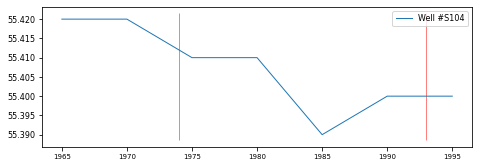

In [23]:
f = "surface-elevation_5y_1965-1995.csv"

fig, ax = plt.subplots()
fig.set_size_inches(2*wu, 1*hu)

tmp = pd.read_csv(os.path.join(work_dir, f), comment='#')
tmp["DATE_TIME"] = pd.to_datetime(tmp["DATE_TIME"], format='%Y')

tmp.set_index("DATE_TIME", inplace=True)
tmp.sort_index(inplace=True)
tmp.info()

wells = sorted(tmp["WELL_NO"].unique())
print(wells)
num = len(wells)
print(num)

wl = "S104"

longest_series = []
for w in wells:
    df = tmp.loc[tmp["WELL_NO"] == w]
    if w == wl:
        df.info()
        longest_series.append(w)
        ax.plot(df.index, df["SURF_ELEV"], linewidth=1, label="Well #%s" % wl)
        # ax.set_xlim((pd.to_datetime("1960-01-01"), pd.to_datetime("1995-01-01")))
        
        ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        
        ymin, ymax = ax.get_ylim()
        ax.vlines(x=pd.to_datetime("1993-01-01"), ymin=ymin, ymax=ymax, linewidth=0.5, color='r')
        ax.vlines(x=pd.to_datetime("1974-01-01"), ymin=ymin, ymax=ymax, linewidth=0.5, color='r')

ax.legend()
fig.tight_layout()

fig_path = os.path.join(fig_dir, "test_surf-elev_%s.png" % wl)
# plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")